# CZII YOLO11 Training Baseline
 We created a training set adapted to YOLO from [the dataset baseline](https://www.kaggle.com/code/itsuki9180/czii-making-datasets-for-yolo).

In this notebook, we actually use it to train YOLO so that it can infer the xy coordinates of particles through 2D object detection.

# Install and Import modules

In [1]:
# !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
# !pip install --no-index --find-links=./packages ultralytics
# !rm -rf ./packages

In [2]:
EXP_NAME = "baseline_cv_syn_data_transfer_mod_last"
LIST_CV = [
    'TS_5_4',
    'TS_69_2',
    'TS_6_4',
    'TS_6_6',
    'TS_73_6',
    'TS_86_3',
    'TS_99_9',
]

PROC_RAW = "proc/yolo11_baseline_cv"

PROC = f"../../{PROC_RAW}"
PROC_YAML = f"/workspace/CZII/{PROC_RAW}"

In [3]:
from tqdm import tqdm
import glob, os
from ultralytics import YOLO

# Prepare to train and instance YOLOmodel

In [4]:
yaml_content = f"""
train: {PROC_YAML}/train.txt
val: {PROC_YAML}/val.txt
nc: 6

# Classes
names:
  0: apo-ferritin
  1: beta-amylase
  2: beta-galactosidase
  3: ribosome
  4: thyroglobulin
  5: virus-like-particle
"""

with open(f'{PROC}/cv_conf.yaml', 'w') as f:
    f.write(yaml_content.strip())

# Let's train YOLO!

In [5]:
def list_all_images(root_dir, extensions="png"):
    """指定ディレクトリ以下の画像ファイルパスを再帰的に取得してリストで返す。"""
    all_paths = []
    search_pattern = os.path.join(root_dir, "**", f"*.{extensions}")
    paths = glob.glob(search_pattern, recursive=True)
    all_paths.extend(paths)
    return all_paths

def contains_val_keyword(path, keyword):
    """
    ファイルパスのファイル名に `keyword` が含まれているか確認。
    Trueならval、Falseならtrainとする。
    """
    filename = os.path.basename(path)  # ディレクトリを除いたファイル名を取得
    return keyword in filename

def extract_train_val_paths(keyword):

    image_paths = list_all_images(f"{PROC_YAML}/images")
    image_paths.sort()
    # print(image_paths)

    train_paths = []
    val_paths   = []

    # ファイル名をみて振り分け
    for p in image_paths:
        if contains_val_keyword(p, keyword):
            val_paths.append(p)
        else:
            train_paths.append(p)

    print(f"Found {len(train_paths)} train images.")
    print(f"Found {len(val_paths)} val images.")

    # train.txt と val.txt に書き出し
    with open(f"{PROC}/train.txt", "w") as f:
        for path in train_paths:
            f.write(path + "\n")

    with open(f"{PROC}/val.txt", "w") as f:
        for path in val_paths:
            f.write(path + "\n")

    print(f"Train list saved to {f"{PROC}/train.txt"}")
    print(f"Val list saved to {f"{PROC}/val.txt"}")

In [6]:
dir_name = "baseline_cv_syn_data_mod"
model_path = f"../../runs/detect/{dir_name}/weights/last.pt"


for cv_name in LIST_CV:
    print("="*100)
    print(f"Processing {cv_name}...")
    extract_train_val_paths(cv_name)

    # Load a pretrained model
    model = YOLO(model_path)  # load a pretrained model (recommended for training)

    # Train the model
    _ = model.train(
        data=f"{PROC}/cv_conf.yaml",
        name=EXP_NAME,
        epochs=25,
        warmup_epochs=3,
        optimizer='AdamW',
        cos_lr=True,
        lr0=5e-5,
        lrf=0.01,
        imgsz=640,
        device="0",
        weight_decay=0.01,
        batch=16,
        scale=0,
        flipud=0.5,
        fliplr=0.5,
        degrees=90,
        shear=5,
        mixup=0.2,
        copy_paste=0.25,
        seed=8620, # (｡•◡•｡)
    )

Processing TS_5_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_baseline_cv/train.txt
Val list saved to ../../proc/yolo11_baseline_cv/val.txt


New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
engine/trainer: task=detect, mode=train, model=../../runs/detect/baseline_cv_syn_data_mod/weights/last.pt, data=../../proc/yolo11_baseline_cv/cv_conf.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=baseline_cv_syn_data_transfer_mod_last, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=8620, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, a

train: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 1104 images, 272 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 188.89it/s]


train: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.2' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 30 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 160.62it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(6403d9d4608f4b01a1d45368c024f0f4) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25        11G      1.149      1.343      1.016        468        640: 100%|██████████| 69/69 [00:29<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        184       2640      0.554      0.542      0.542      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25        11G      1.098      1.157      1.001        498        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        184       2640      0.565      0.556      0.572      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25        11G      1.063      1.113     0.9902        303        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2640      0.576      0.579      0.605      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25        11G      1.061      1.107     0.9874        505        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.619      0.571      0.619      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25        11G      1.055      1.079      0.983        526        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.623      0.615      0.638      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25        11G      1.045      1.072     0.9822        498        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

                   all        184       2640      0.606      0.578      0.617      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25        11G      1.036      1.057     0.9785        266        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

                   all        184       2640      0.589      0.603      0.621       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25        11G      1.026      1.046     0.9734        318        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       2640      0.615      0.582      0.632      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      10.9G      1.019      1.048      0.971        327        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        184       2640      0.593      0.601      0.629       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.1G      1.007      1.033     0.9684        388        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640      0.574      0.626      0.623       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25        11G     0.9946      1.044     0.9674        414        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2640      0.611      0.617      0.643      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25        11G      1.004      1.032     0.9657        416        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        184       2640      0.622      0.602      0.642      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25        11G     0.9963      1.011     0.9637        627        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640      0.598      0.598      0.633      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25        11G     0.9876      1.004     0.9623        463        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640       0.61      0.602      0.625       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.1G     0.9934      1.013     0.9646        333        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       2640      0.588        0.6      0.623      0.432


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      10.9G      0.901     0.9323     0.9238        303        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.576      0.604      0.631      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      10.8G     0.9015     0.9133     0.9254        394        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       2640      0.556      0.604      0.625      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      10.9G     0.9006     0.9134     0.9256        449        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all        184       2640      0.593      0.609      0.634      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25        11G     0.8949     0.8937     0.9243        284        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640        0.6      0.597      0.626      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      10.9G     0.8895     0.8966     0.9192        368        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.575      0.601      0.621      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      10.9G     0.8767      0.874     0.9191        337        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        184       2640      0.595      0.606       0.63      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25        11G      0.876     0.8724     0.9179        360        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2640      0.584      0.592      0.624      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25        11G     0.8765     0.8801     0.9181        201        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        184       2640      0.601      0.599      0.626      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      10.9G     0.8763     0.8687     0.9175        217        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640      0.589      0.602      0.625      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      10.9G     0.8714     0.8662     0.9162        446        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.586        0.6      0.625      0.446



25 epochs completed in 0.225 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


                   all        184       2640      0.622      0.602      0.642      0.462
          apo-ferritin        133        506      0.702      0.747      0.774      0.523
    beta-galactosidase        112        200      0.459      0.295      0.312      0.183
              ribosome        145        899      0.793      0.701       0.82      0.594
         thyroglobulin        144        749      0.412      0.326      0.342      0.231
   virus-like-particle        105        286      0.746      0.941      0.961      0.777
Speed: 0.2ms preprocess, 23.3ms inference, 0.0ms loss, 13.4ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_69_2...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_baseline_cv/train.txt
Val list saved to ../../proc/yolo11_baseline_cv/val.txt
New https

train: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 1104 images, 220 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 189.19it/s]

train: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 82 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 178.38it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last2/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(18e2880a6a4e4970bd86a9efdb3a61ad) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.156      1.356      1.018        479        640: 100%|██████████| 69/69 [00:30<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.648      0.511      0.552      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.6G      1.112      1.162      1.003        496        640: 100%|██████████| 69/69 [00:28<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.563      0.546      0.583      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.5G      1.067      1.115     0.9911        274        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814      0.609      0.621      0.643      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.057      1.108     0.9852        514        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2814      0.635      0.613       0.64      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.052      1.097     0.9815        527        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.629      0.611      0.632       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.046      1.088     0.9834        457        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        184       2814      0.628      0.626      0.635       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.035      1.068     0.9789        254        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all        184       2814      0.619      0.606       0.63      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G       1.03      1.054     0.9749        315        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2814      0.623      0.633      0.643      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.023      1.046     0.9712        333        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        184       2814      0.619      0.611      0.636      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.7G      1.006      1.026      0.966        374        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814      0.616      0.632      0.647      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G       0.99      1.026      0.965        424        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

                   all        184       2814      0.647      0.629      0.649      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.001      1.031     0.9644        410        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814       0.61      0.621      0.636      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G     0.9995      1.011     0.9638        599        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]

                   all        184       2814      0.608      0.635      0.632      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G     0.9868      1.008     0.9617        455        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2814      0.612      0.643      0.637      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.6G     0.9877      1.006     0.9616        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814      0.618      0.633      0.638      0.471


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G     0.9041     0.9306     0.9251        337        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.589      0.637      0.634      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.4G      0.897     0.9103     0.9236        370        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

                   all        184       2814       0.58      0.648      0.624      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G     0.8935     0.9071     0.9231        448        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2814      0.601      0.631      0.632      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G     0.8912     0.8942     0.9235        283        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814      0.612      0.625      0.627      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.5G      0.882     0.8789     0.9167        348        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.596      0.633      0.629      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G     0.8738     0.8718      0.918        347        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.601      0.627      0.625      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G     0.8737     0.8706     0.9175        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814      0.595      0.631      0.623      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G     0.8653     0.8616     0.9155        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814        0.6      0.628      0.624      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G     0.8698     0.8591     0.9157        204        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       2814      0.595      0.627      0.622      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G     0.8657     0.8607     0.9143        391        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       2814      0.591      0.631      0.621      0.452



25 epochs completed in 0.224 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last2/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last2/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last2/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


                   all        184       2814      0.608       0.62      0.643      0.471
          apo-ferritin         75        385      0.634       0.73      0.677       0.46
    beta-galactosidase         86        272      0.482      0.404      0.406      0.228
              ribosome         96       1073      0.822      0.811      0.898      0.674
         thyroglobulin        100        850      0.446      0.211      0.282      0.172
   virus-like-particle         56        234      0.654      0.944       0.95      0.823
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last2
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_baseline_cv/train.txt
Val list saved to ../../proc/yolo11_baseline_cv/val.txt
New https:/

train: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 1104 images, 263 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 190.02it/s]


train: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 170.92it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last3/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(d1748b54689b461c95c734fc294d7f1d) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.149      1.382      1.012        461        640: 100%|██████████| 69/69 [00:30<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.518      0.506      0.487      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.7G      1.092      1.183     0.9944        472        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       3998      0.547       0.56      0.545      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.5G       1.06      1.131     0.9849        258        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.534      0.593       0.57      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.5G      1.055      1.119     0.9812        446        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       3998        0.5      0.559      0.559      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.5G      1.054      1.105     0.9804        512        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.537      0.583       0.57      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.035      1.111     0.9778        439        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998       0.53      0.598      0.574       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.033      1.088      0.977        206        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.568      0.588      0.576      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.029      1.069     0.9723        313        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       3998      0.528      0.593      0.572      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.019      1.065     0.9688        308        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       3998      0.545      0.587      0.577      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.7G     0.9986      1.042     0.9633        376        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.573       0.57      0.573      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G     0.9816      1.044     0.9608        429        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.565      0.594      0.581      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      0.995      1.044     0.9611        385        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.565       0.59      0.569      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G     0.9935      1.027     0.9608        584        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

                   all        184       3998      0.558      0.596      0.577       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G     0.9773      1.024     0.9579        435        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       3998      0.547      0.609       0.58      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.6G     0.9802      1.022     0.9583        334        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       3998      0.556      0.596      0.579       0.41


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G     0.8998     0.9458      0.923        326        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.534      0.603      0.584      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.4G     0.8885     0.9278       0.92        370        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998      0.548      0.597      0.585      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G     0.8839     0.9181     0.9182        441        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       3998      0.581      0.589      0.586      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      0.881     0.9042     0.9189        260        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998       0.58      0.589      0.584      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G     0.8724     0.8999     0.9149        339        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.556        0.6      0.584       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G     0.8654     0.8932     0.9153        335        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.574      0.591      0.585      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.6G     0.8591     0.8836     0.9114        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        184       3998      0.585      0.579      0.587      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G     0.8542     0.8763     0.9103        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.579       0.59      0.585      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G     0.8578     0.8778     0.9121        190        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998       0.59      0.585      0.584      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G     0.8564     0.8733       0.91        362        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.592      0.579      0.583      0.418



25 epochs completed in 0.225 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last3/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last3/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last3/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


                   all        184       3998      0.581       0.58      0.587      0.422
          apo-ferritin        121        638      0.691      0.798      0.796       0.57
    beta-galactosidase         89        204       0.38      0.221      0.265      0.153
              ribosome        129       2146      0.673      0.867      0.783      0.557
         thyroglobulin        125        750      0.482      0.287      0.348      0.211
   virus-like-particle         75        260      0.679      0.727       0.74      0.619
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last3
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_6...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_baseline_cv/train.txt
Val list saved to ../../proc/yolo11_baseline_cv/val.txt
New https:/

train: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 1104 images, 278 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 188.89it/s]


train: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 24 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 165.31it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last4/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(7c47e7b326034626aa62514075b783db) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.144      1.351      1.012        529        640: 100%|██████████| 69/69 [00:29<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        184       2674      0.508      0.392      0.462       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.8G      1.092      1.158     0.9974        491        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        184       2674      0.549      0.604      0.578      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G      1.056      1.114     0.9856        261        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.586      0.603       0.61      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.052      1.105     0.9825        459        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2674      0.566      0.624      0.616      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.055      1.069     0.9824        537        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.575      0.617      0.614      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.036      1.095     0.9802        476        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.597       0.61      0.623      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.032      1.083     0.9763        222        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.578      0.618      0.624      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.022      1.053     0.9718        315        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2674      0.578      0.622      0.625      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.018      1.048     0.9706        384        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.588      0.632      0.632      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.8G      1.003      1.028     0.9684        386        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.569      0.645      0.629      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G     0.9829       1.04     0.9642        469        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.545      0.631       0.62      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G     0.9962      1.043     0.9642        423        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        184       2674      0.577      0.627      0.625      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G     0.9986      1.014     0.9646        612        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       2674      0.593      0.611      0.627      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G     0.9742      1.008     0.9599        480        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.561      0.638      0.623      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G     0.9796      1.003       0.96        332        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       2674      0.548      0.649      0.628       0.45


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.6G     0.8978     0.9372     0.9236        326        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       2674      0.546      0.634      0.629      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G     0.8877     0.9183     0.9224        363        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        184       2674      0.564      0.634      0.632      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.6G     0.8822     0.9086      0.919        438        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]

                   all        184       2674      0.619      0.608      0.636      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G     0.8807     0.8922     0.9205        260        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.622      0.594      0.628      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G      0.875     0.8918     0.9184        363        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.564      0.616      0.623      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G     0.8669     0.8791     0.9182        331        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.621      0.592      0.628      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G      0.864     0.8764      0.915        365        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.579      0.625      0.627       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G     0.8594     0.8721     0.9134        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.607      0.601      0.627      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G     0.8586     0.8736     0.9159        214        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.605      0.602      0.626      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G     0.8602     0.8672     0.9139        395        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        184       2674      0.608      0.603      0.626      0.452



25 epochs completed in 0.250 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last4/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last4/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last4/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


                   all        184       2674      0.617      0.609      0.636       0.46
          apo-ferritin        149        451      0.649      0.736      0.727      0.536
    beta-galactosidase         84        187      0.427      0.251      0.329      0.203
              ribosome        106        667      0.843       0.85      0.913        0.6
         thyroglobulin        144        875      0.364      0.277      0.259      0.158
   virus-like-particle        127        494        0.8      0.929      0.955      0.801
Speed: 0.2ms preprocess, 39.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last4
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_73_6...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_baseline_cv/train.txt
Val list saved to ../../proc/yolo11_baseline_cv/val.txt
New https

train: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 1104 images, 263 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 188.14it/s]

train: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 180.97it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last5/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(2b08821b69e548a6aa0195a01cc4ced9) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.141       1.37      1.013        507        640: 100%|██████████| 69/69 [00:32<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3860      0.626      0.474      0.508      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.8G      1.092      1.165     0.9983        445        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       3860      0.537      0.566      0.533      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G      1.064      1.134     0.9904        254        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       3860      0.544      0.567      0.558      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.066      1.123     0.9876        427        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        184       3860      0.541      0.577      0.558      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.057      1.096     0.9826        503        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860      0.528       0.59      0.555      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.045      1.107     0.9836        459        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       3860      0.564      0.561      0.565      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.7G      1.038      1.078     0.9789        204        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       3860       0.55      0.592      0.569      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.038      1.064     0.9767        268        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3860      0.591      0.555      0.571      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.7G      1.031      1.057     0.9753        394        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3860       0.58      0.554      0.564      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.8G      1.026      1.045     0.9766        381        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860      0.566      0.569      0.571       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G     0.9958      1.036     0.9663        418        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]

                   all        184       3860      0.535      0.587      0.568      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.005      1.041     0.9664        338        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3860      0.591      0.569      0.577      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.014      1.034     0.9694        563        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       3860      0.597      0.553      0.574      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G     0.9911      1.021     0.9648        445        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       3860      0.552      0.575      0.569      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.9G     0.9921      1.012     0.9637        312        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]

                   all        184       3860      0.573      0.556       0.57      0.408


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.6G      0.912     0.9401     0.9285        300        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all        184       3860      0.539      0.574      0.569      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G     0.9029     0.9208     0.9268        352        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860      0.547      0.566      0.564      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.6G     0.8971     0.9145     0.9225        439        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       3860      0.541      0.591      0.566      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      0.896      0.901     0.9245        235        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3860      0.546      0.594      0.568      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G     0.8902     0.8917     0.9223        344        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3860       0.54      0.587      0.573       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.6G     0.8853     0.8869     0.9233        280        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       3860      0.555      0.583      0.576       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G     0.8835     0.8802     0.9195        337        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        184       3860      0.555      0.575      0.572      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G     0.8773     0.8735     0.9179        207        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]

                   all        184       3860      0.566       0.57      0.571      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G     0.8752       0.87     0.9188        214        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3860      0.545      0.586      0.571      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.6G      0.873     0.8678     0.9163        397        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3860      0.546      0.584      0.571      0.418



25 epochs completed in 0.251 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last5/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last5/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last5/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


                   all        184       3860      0.553      0.576      0.572      0.422
          apo-ferritin        137       1036      0.544       0.73      0.658       0.47
    beta-galactosidase         97        238      0.381      0.254      0.281      0.169
              ribosome        145       1328      0.702      0.807      0.825      0.593
         thyroglobulin        142        694      0.262      0.232      0.171      0.106
   virus-like-particle        114        564      0.878      0.858      0.924      0.772
Speed: 0.2ms preprocess, 23.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last5
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_86_3...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_baseline_cv/train.txt
Val list saved to ../../proc/yolo11_baseline_cv/val.txt
New https

train: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 1104 images, 253 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 192.27it/s]

train: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 49 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 156.69it/s]

val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last6/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(f09d39658d7d42aca703577bafc2c203) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last6
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.131      1.399      1.009        491        640: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]

                   all        184       4569      0.558      0.409      0.505      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.7G      1.089      1.184     0.9955        385        640: 100%|██████████| 69/69 [00:29<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        184       4569      0.623      0.622       0.63      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G      1.052      1.153     0.9837        261        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       4569      0.631      0.638      0.653      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.5G       1.05      1.141     0.9801        367        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       4569      0.603      0.654      0.656      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.042      1.112     0.9764        481        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       4569      0.634      0.652      0.664      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.032      1.117     0.9766        487        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4569      0.662      0.645      0.655      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.027      1.099     0.9755        203        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       4569      0.629      0.652      0.655      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.018       1.08     0.9687        262        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       4569      0.655      0.638      0.657      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.014       1.09     0.9687        363        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

                   all        184       4569      0.641      0.657      0.657      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.8G      1.006      1.066     0.9689        387        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       4569       0.66      0.643      0.654      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.7G     0.9838      1.054     0.9591        427        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

                   all        184       4569      0.654      0.646      0.662      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.5G     0.9858      1.062     0.9596        361        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

                   all        184       4569       0.65      0.668      0.657      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G     0.9918      1.041     0.9613        502        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        184       4569      0.647      0.648       0.66      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G     0.9796      1.034     0.9612        467        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4569      0.635      0.656      0.665      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G     0.9861      1.037     0.9597        341        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       4569      0.657      0.641      0.658      0.438


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G     0.8872     0.9518     0.9211        251        640: 100%|██████████| 69/69 [00:29<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4569      0.641      0.656      0.664      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G     0.8775     0.9242      0.919        298        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       4569      0.635       0.65       0.66      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.6G     0.8758     0.9249      0.916        364        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

                   all        184       4569      0.647      0.656       0.66      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.5G      0.867     0.9052      0.915        233        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4569      0.642      0.656      0.654      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G     0.8672     0.9007     0.9154        308        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       4569      0.637      0.645       0.66      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G     0.8556     0.8873     0.9142        294        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       4569       0.65      0.636       0.66      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.6G      0.855     0.8832     0.9097        310        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       4569      0.642      0.645      0.659      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G     0.8541     0.8813     0.9113        185        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       4569      0.639      0.651      0.658      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      0.847     0.8736      0.911        200        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

                   all        184       4569      0.636      0.652      0.657      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G     0.8448      0.867     0.9083        385        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4569      0.639      0.649      0.658      0.457



25 epochs completed in 0.251 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last6/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last6/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last6/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


                   all        184       4569      0.642      0.646      0.659      0.466
          apo-ferritin         98        704      0.713      0.756      0.791      0.552
    beta-galactosidase         87        391      0.513      0.297      0.388      0.226
              ribosome        101       1595      0.766      0.857      0.829      0.556
         thyroglobulin        135       1125      0.377      0.368      0.315       0.18
   virus-like-particle         89        754      0.844      0.951      0.972      0.815
Speed: 1.3ms preprocess, 17.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last6
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_99_9...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_baseline_cv/train.txt
Val list saved to ../../proc/yolo11_baseline_cv/val.txt
New https

train: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 1104 images, 263 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 185.19it/s]


train: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_baseline_cv/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 171.52it/s]


val: New cache created: /workspace/CZII/proc/yolo11_baseline_cv/labels.cache
Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last7/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(a3caedb8d6034b90969ed4c490f46cf3) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last7
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G       1.15      1.381      1.013        492        640: 100%|██████████| 69/69 [00:29<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       4244      0.613      0.437      0.519      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.5G       1.09      1.167      0.995        371        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       4244      0.568      0.562      0.577      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.7G      1.049      1.129     0.9806        255        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       4244      0.612      0.549      0.593      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.5G      1.051       1.11     0.9801        381        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4244      0.606      0.591      0.616      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.052      1.095     0.9783        497        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4244      0.598      0.575      0.608       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.039      1.095     0.9771        468        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        184       4244      0.567      0.589      0.598       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.027      1.077     0.9736        212        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        184       4244      0.598      0.598      0.608      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.7G      1.019      1.052     0.9689        253        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]

                   all        184       4244      0.601      0.581      0.607      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.025      1.057     0.9709        405        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4244      0.576      0.588      0.607      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.6G      1.009      1.038     0.9692        359        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4244      0.598      0.581        0.6      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.7G     0.9911      1.026       0.96        456        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

                   all        184       4244      0.598      0.581      0.601      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.003      1.052     0.9627        355        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4244      0.541      0.599      0.599      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G          1      1.021     0.9613        411        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4244      0.579      0.582      0.602      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.5G     0.9795      1.015     0.9586        450        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       4244       0.57      0.595      0.602      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G     0.9859      1.017      0.956        286        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4244      0.577      0.596      0.609       0.44


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.6G     0.9011     0.9271     0.9238        277        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       4244      0.585      0.581      0.603      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.6G     0.8936     0.9088      0.921        348        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        184       4244      0.547      0.596      0.599      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.6G     0.8849     0.8986      0.916        372        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       4244      0.586      0.592      0.605      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G     0.8756     0.8851     0.9143        267        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       4244      0.591      0.585      0.607      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G     0.8815     0.8857     0.9164        330        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4244      0.608      0.578      0.611       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G     0.8669     0.8719     0.9136        329        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       4244      0.618      0.582       0.61      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G     0.8675     0.8646     0.9122        294        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

                   all        184       4244      0.595      0.582      0.609       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G     0.8645     0.8616     0.9123        219        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]

                   all        184       4244      0.618      0.573      0.608      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.6G     0.8627     0.8613     0.9116        188        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       4244      0.622      0.574      0.608      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.6G     0.8596     0.8606     0.9106        378        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4244      0.618      0.576      0.608      0.447



25 epochs completed in 0.249 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last7/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last7/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last7/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


                   all        184       4244      0.594      0.583      0.609       0.45
          apo-ferritin        109        396      0.691      0.768      0.784       0.58
    beta-galactosidase        106        408       0.35      0.174      0.194      0.103
              ribosome        145       1883      0.722      0.733      0.791      0.566
         thyroglobulin        144       1219      0.409      0.294      0.315      0.199
   virus-like-particle         81        338      0.797      0.947      0.962      0.804
Speed: 0.2ms preprocess, 6.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_mod_last7
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [7]:
# model = YOLO(f"../../runs/detect/{EXP_NAME}/weights/best.pt")
# metrics = model.val(data=f"{PROC}/czii_conf.yaml", imgsz=640, batch=16, conf=0.25, iou=0.6, device="0", save_json=True)  # no arguments needed, dataset and settings remembered
# print(metrics.box.map)  # map50-95
# print(metrics.box.map50)  # map50
# print(metrics.box.map75)  # map75
# print(metrics.box.maps)

# Prediction example

In [8]:
import pandas as pd
from IPython.display import display, HTML
from IPython.display import Image as IPyImage
pd.options.display.precision = 3

columns = [
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
]
df_result = pd.DataFrame(columns=columns)
for i in range(len(LIST_CV)):
    if i == 0:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}/results.csv")
    else:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}{i+1}/results.csv")
    
    list_results = [
        df.iloc[-1]["metrics/precision(B)"],
        df.iloc[-1]["metrics/recall(B)"],
        df.iloc[-1]["metrics/mAP50(B)"],
        df.iloc[-1]["metrics/mAP50-95(B)"],
    ]
    df_result.loc[f"val_{LIST_CV[i]}"] = list_results
df_result.loc["mean"] = df_result.mean()
df_result

,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
val_TS_5_4,0.586,0.600,0.625,0.446
val_TS_69_2,0.591,0.631,0.621,0.452
val_TS_6_4,0.592,0.579,0.583,0.418
val_TS_6_6,0.608,0.603,0.626,0.452
val_TS_73_6,0.546,0.584,0.571,0.418
val_TS_86_3,0.639,0.649,0.658,0.457
val_TS_99_9,0.618,0.576,0.608,0.447
mean,0.597,0.603,0.613,0.442


In [9]:
# 画像を2x2のグリッドで表示
html_content = '''
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
</div>
'''.format(
    EXP_NAME,
    f"{EXP_NAME}2",
    f"{EXP_NAME}3",
    f"{EXP_NAME}4"
)

display(HTML(html_content))

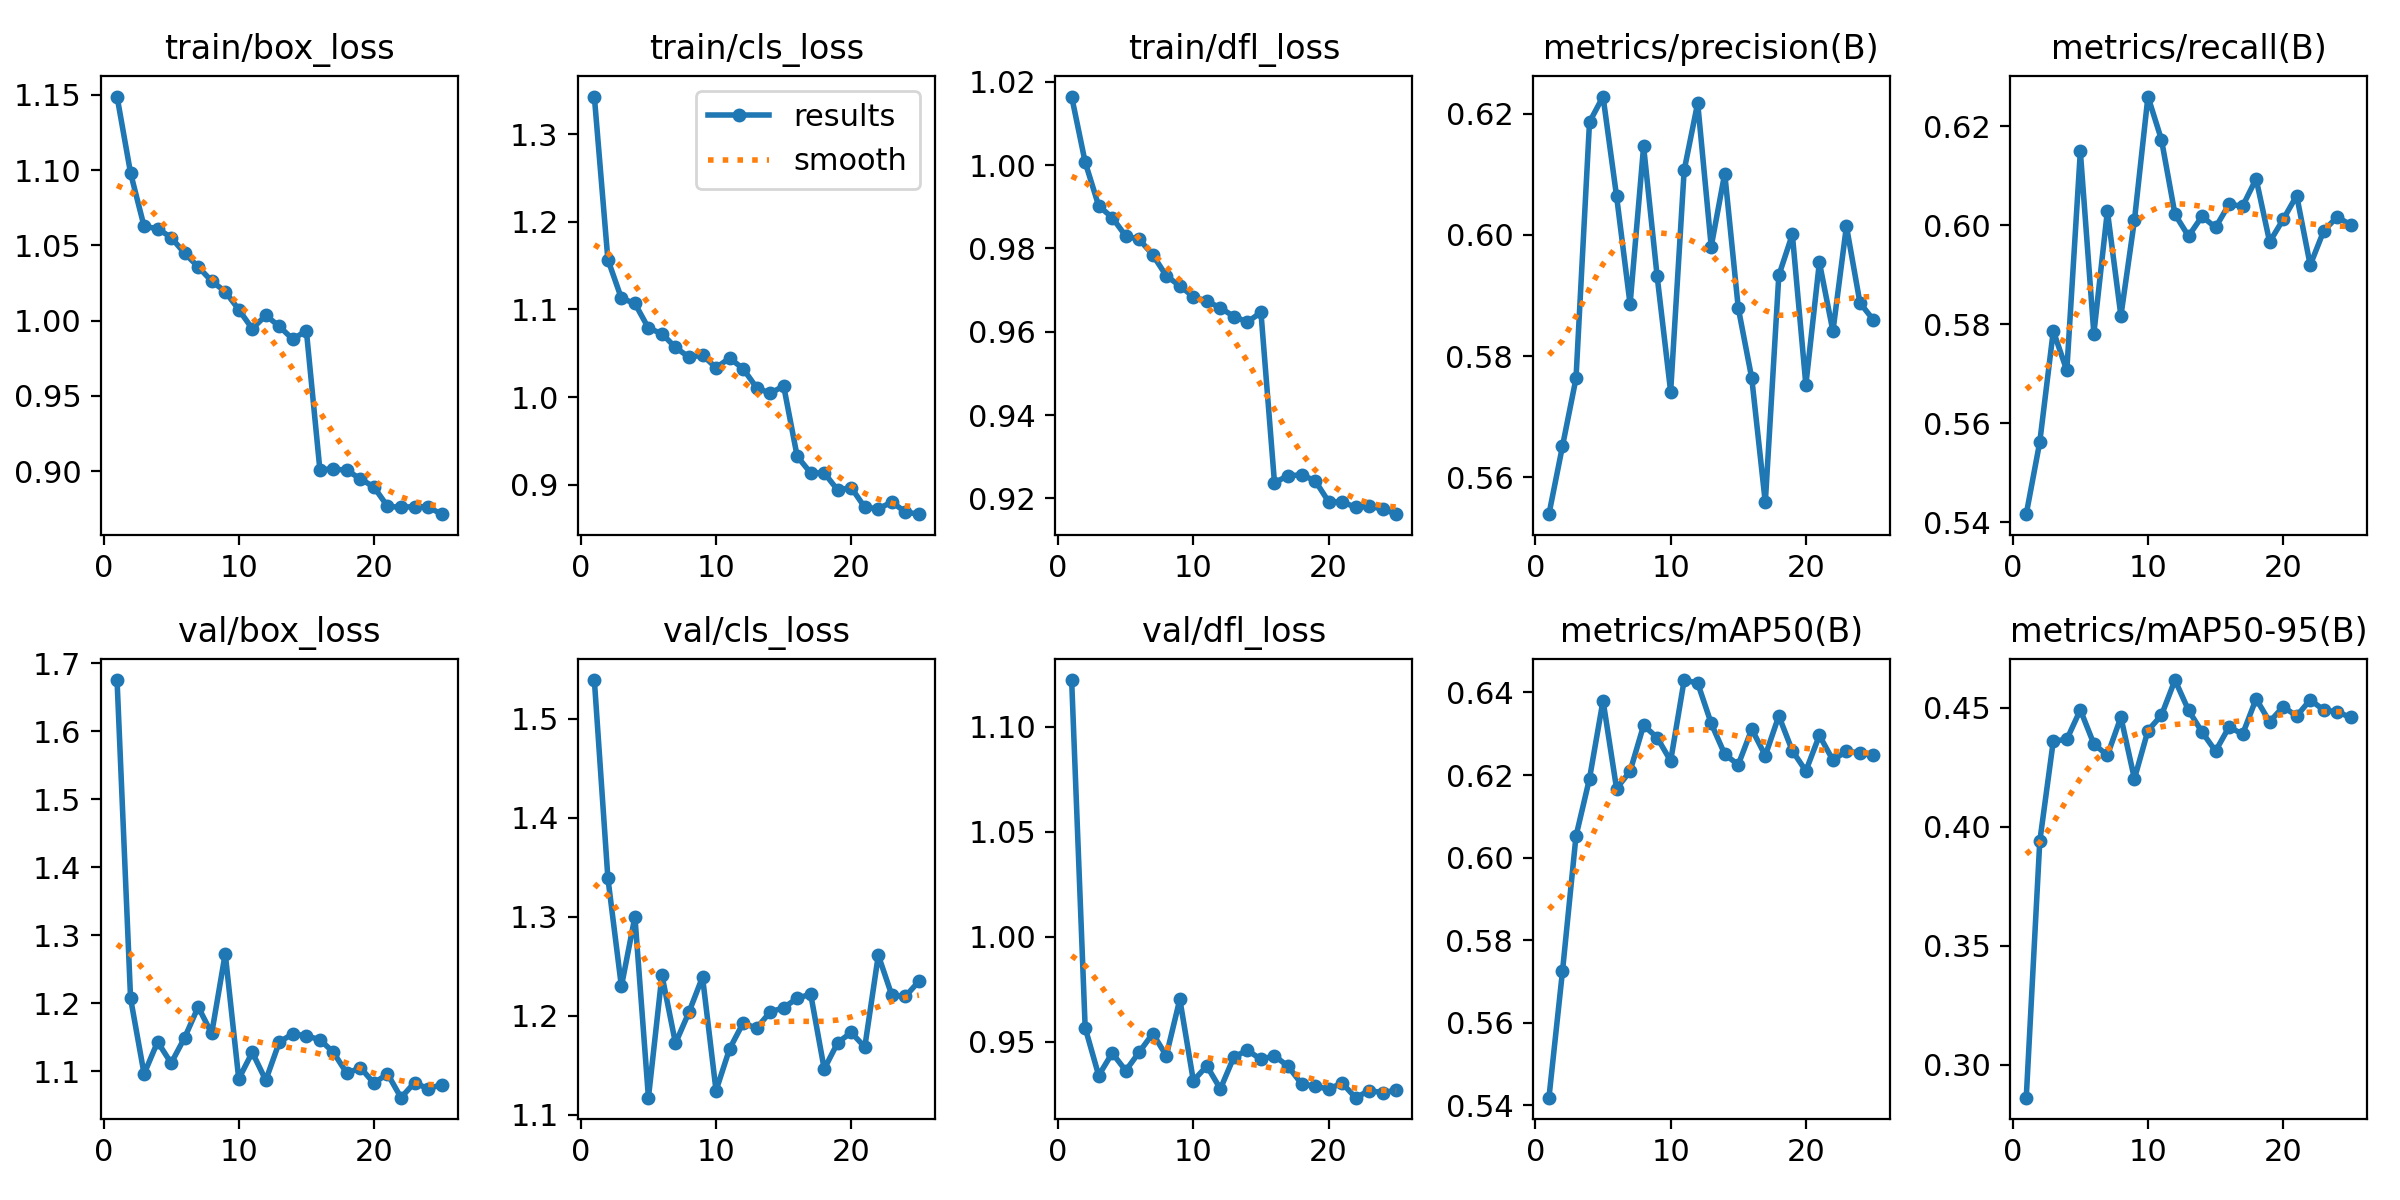

In [10]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}/results.png', width=800)